      f  alpha       c  U_infinity     delta     SSPL
0   800    0.0  0.3048        71.3  0.002663  126.201
1  1000    0.0  0.3048        71.3  0.002663  125.201
2  1250    0.0  0.3048        71.3  0.002663  125.951
3  1600    0.0  0.3048        71.3  0.002663  127.591
4  2000    0.0  0.3048        71.3  0.002663  127.461
Summary Statistics:
                  f        alpha            c   U_infinity        delta  \
count   1503.000000  1503.000000  1503.000000  1503.000000  1503.000000   
mean    2886.380572     6.782302     0.136548    50.860745     0.011140   
std     3152.573137     5.918128     0.093541    15.572784     0.013150   
min      200.000000     0.000000     0.025400    31.700000     0.000401   
25%      800.000000     2.000000     0.050800    39.600000     0.002535   
50%     1600.000000     5.400000     0.101600    39.600000     0.004957   
75%     4000.000000     9.900000     0.228600    71.300000     0.015576   
max    20000.000000    22.200000     0.304800    71.3000

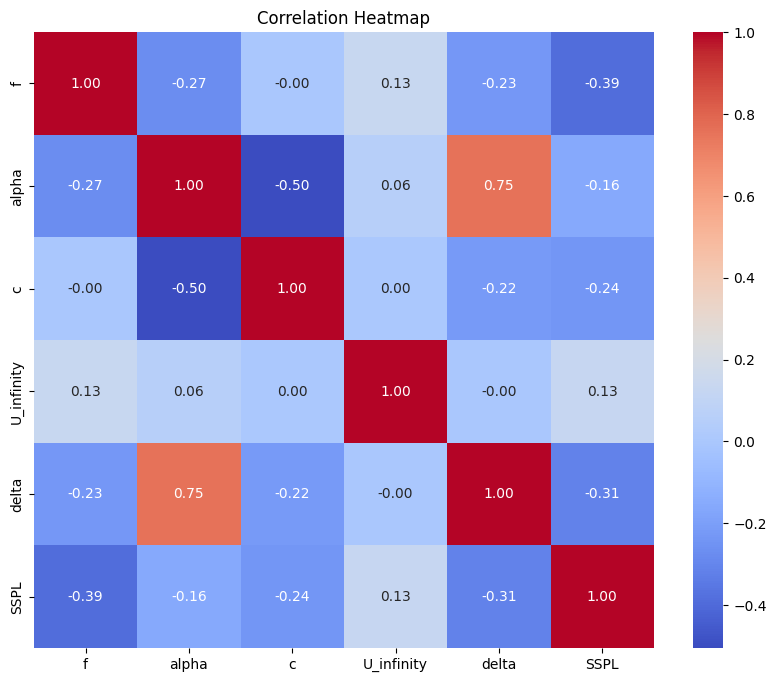

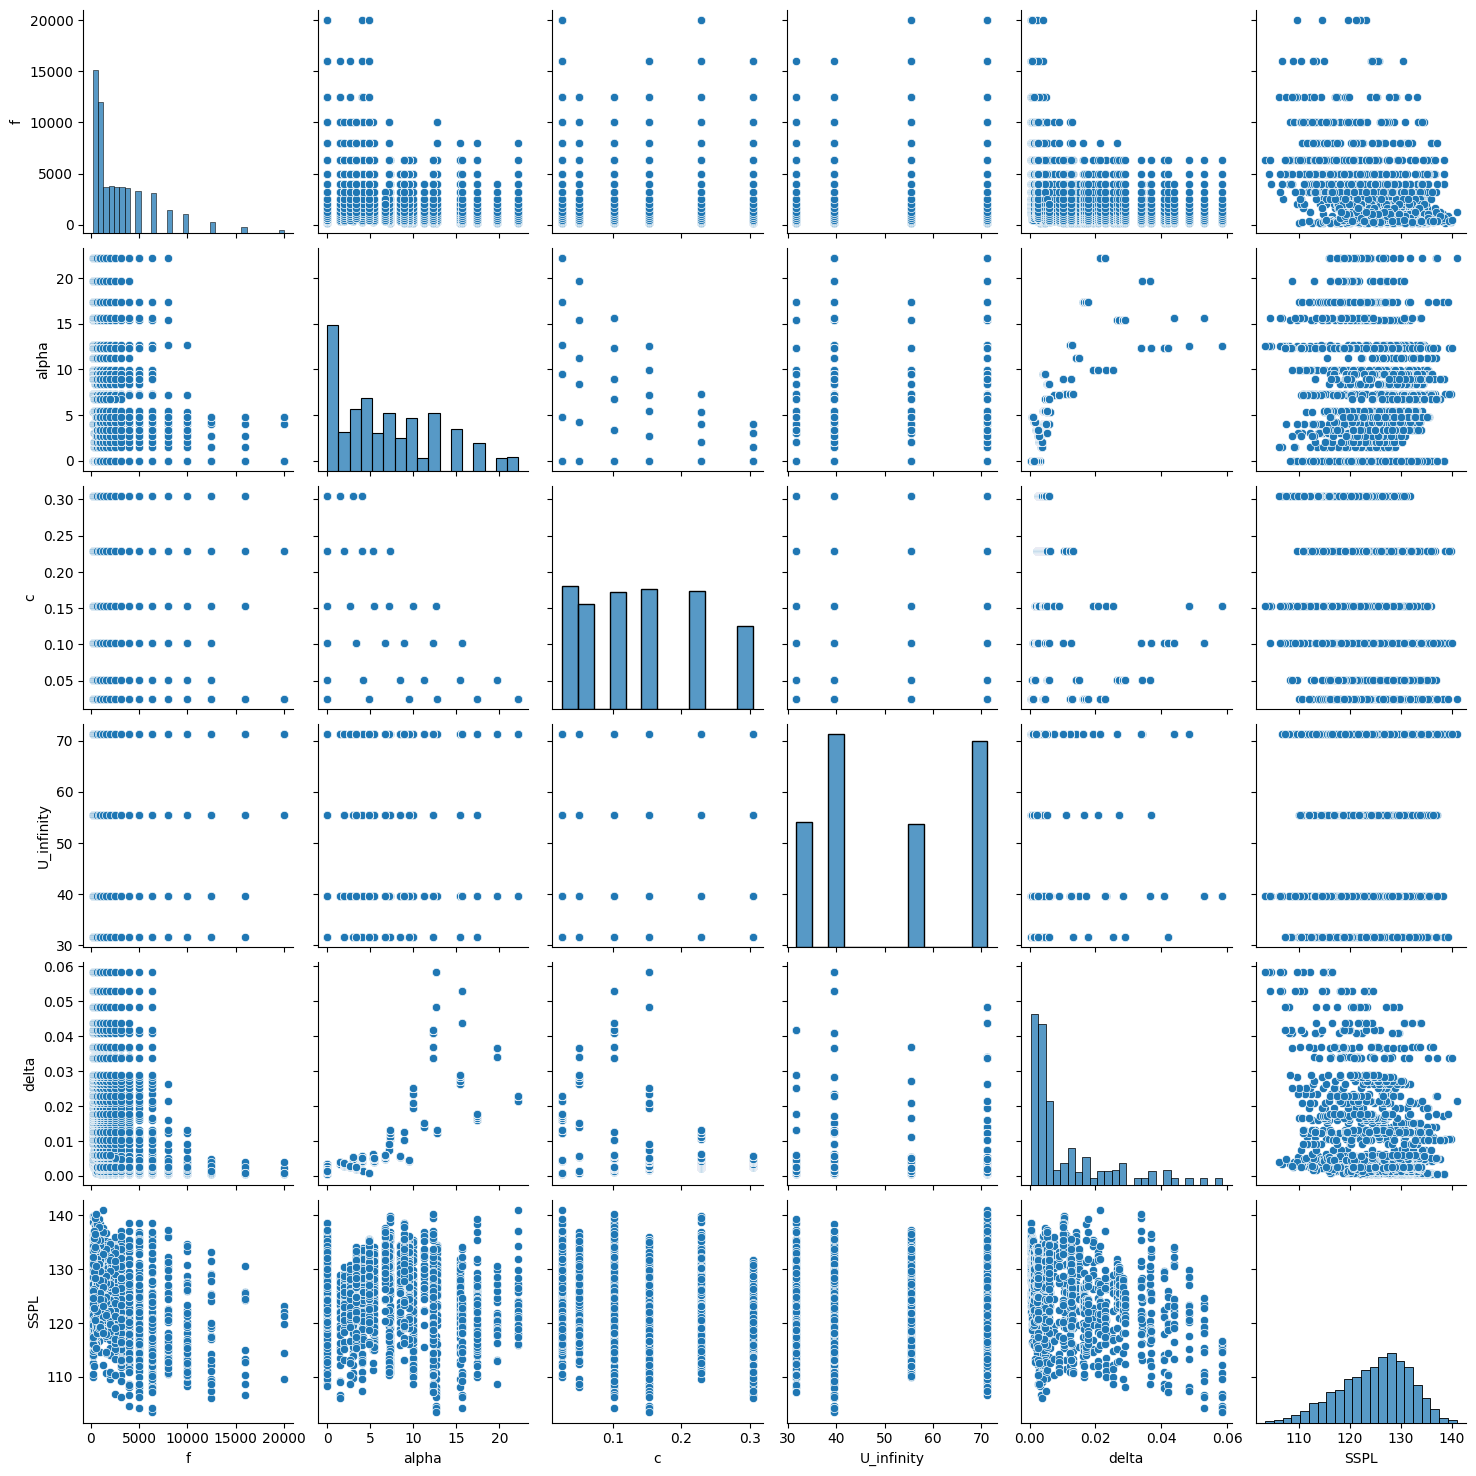

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l2

# Download latest version
path = kagglehub.dataset_download("fedesoriano/airfoil-selfnoise-dataset")

# Now extract to dataframe
dataset = pd.read_csv(path + "/AirfoilSelfNoise.csv")
print(dataset.head())

# Summary statistics
print("Summary Statistics:")
print(dataset.describe())

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.savefig("correlation_heatmap.png")

# Pairplot
sns.pairplot(dataset)
plt.savefig("pairplot.png")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Squared Error (MSE): 7.744061207178942
R-squared: 0.8353693831937354


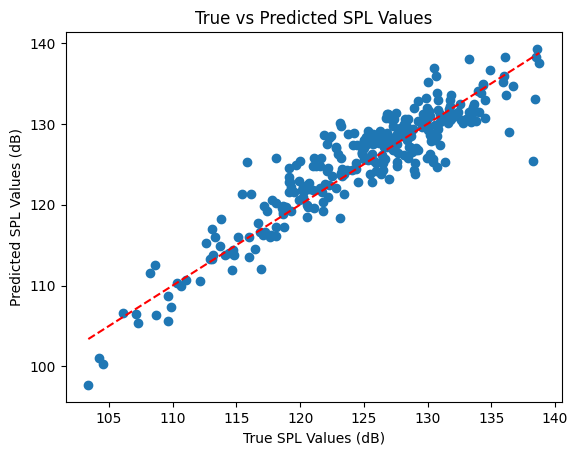

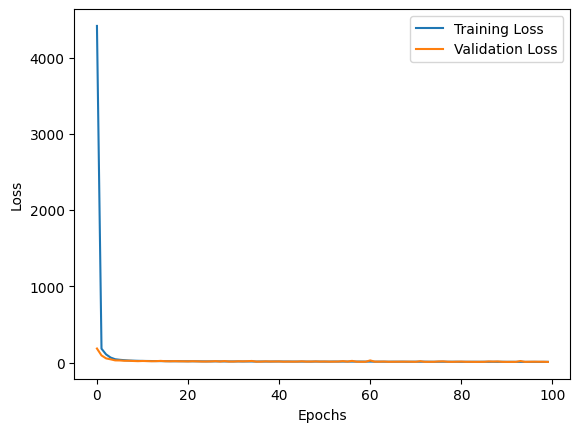

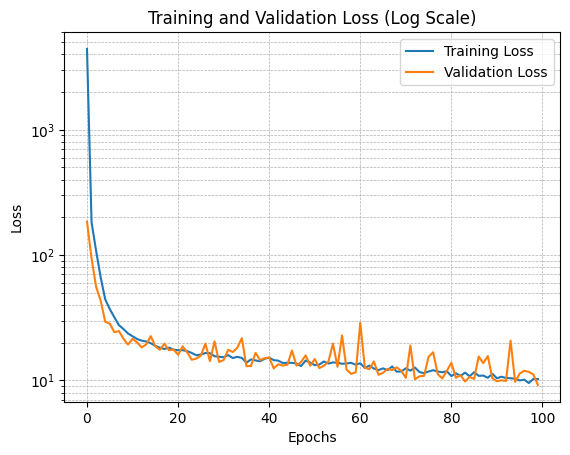

In [ ]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Build the ANN
ann = tf.keras.models.Sequential()

ann.add(tf.keras.layers.Input(shape=(5,)))  # Input layer
ann.add(tf.keras.layers.Dense(units=16, activation='relu' ))
ann.add(tf.keras.layers.Dense(units=16, activation='relu' ))
ann.add(tf.keras.layers.Dense(units=16, activation='relu' ))
ann.add(tf.keras.layers.Dense(units=1))  # Output layer

# Compile the model
# ann.compile(optimizer='adam', loss='mean_squared_error')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
ann.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = ann.fit(X_train, y_train, validation_split=0.2, batch_size=1, epochs=100, verbose=0) # batch_size=32, epochs=100 # Using batch size 1 works the best - wtf

# Evaluate model performance on the test set
y_pred = ann.predict(X_test)

# Metrics: MSE and R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r2}')

# Visualize the results
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True SPL Values (dB)')
plt.ylabel('Predicted SPL Values (dB)')
plt.title('True vs Predicted SPL Values')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.legend()
plt.title('Training and Validation Loss (Log Scale)')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Add grid for better visualization
plt.show()


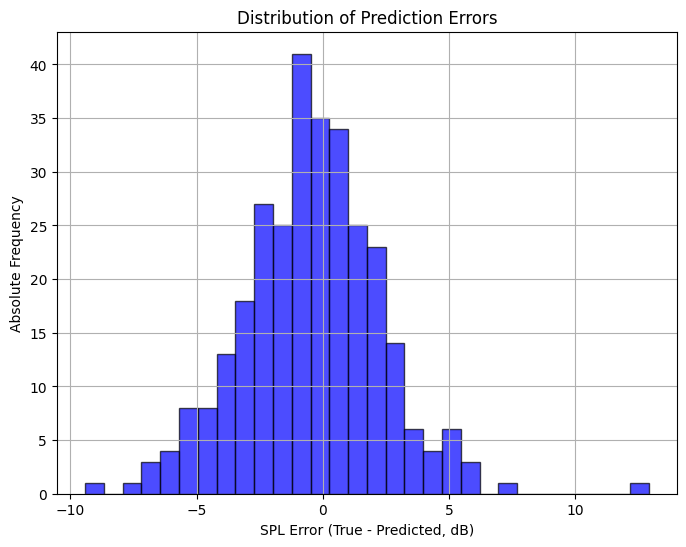

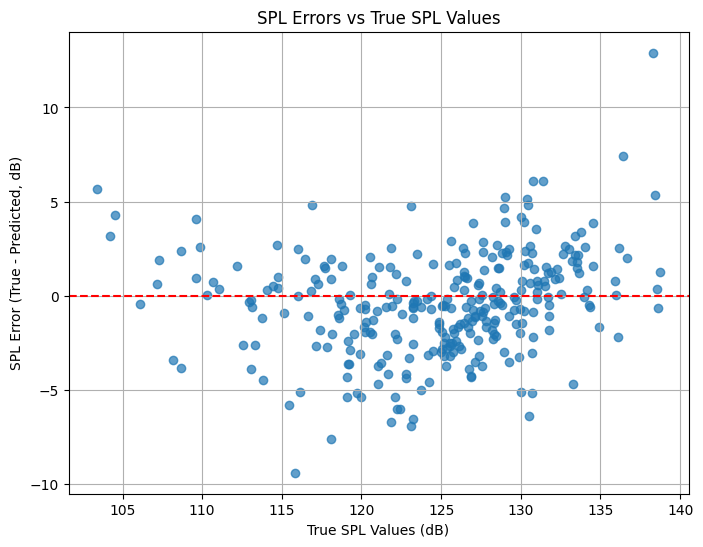

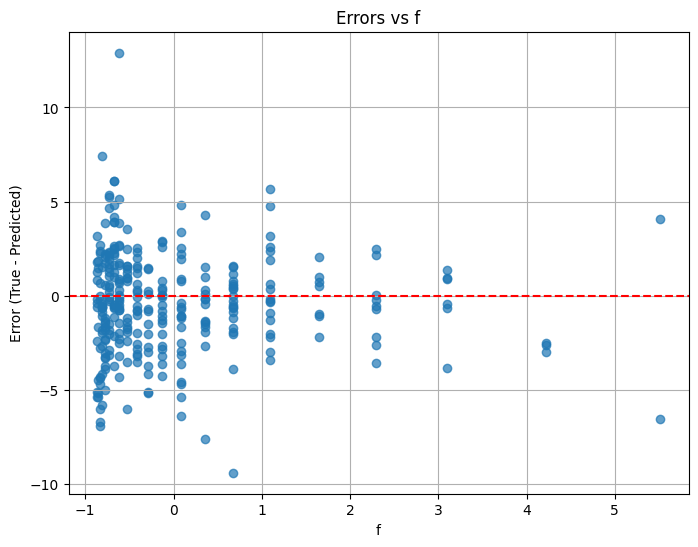

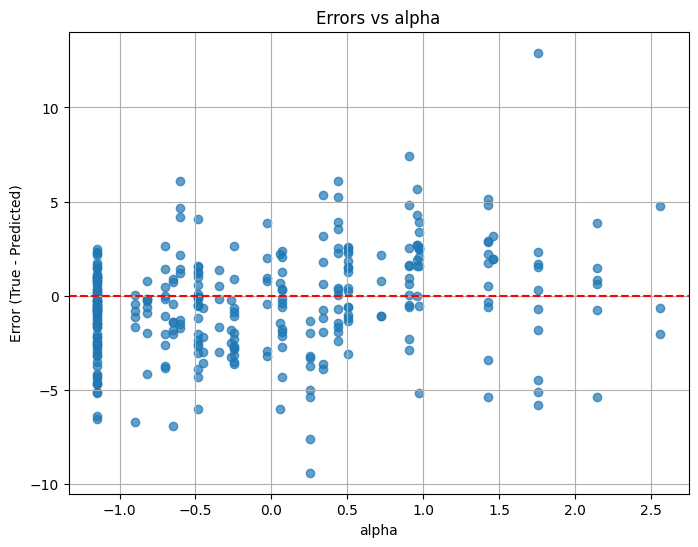

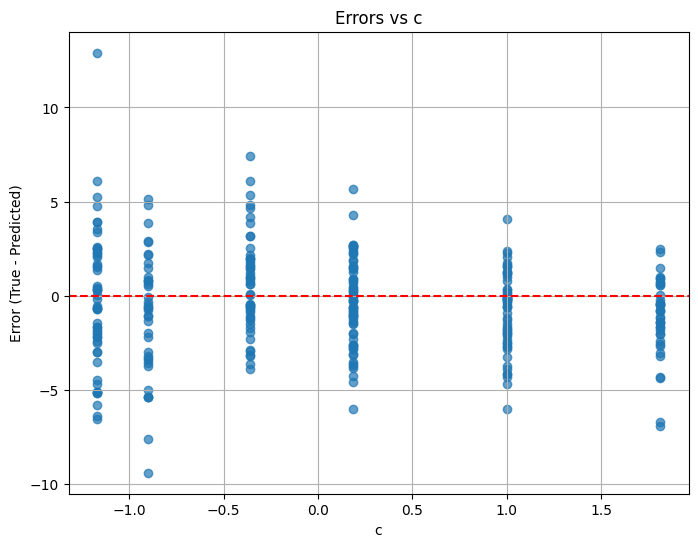

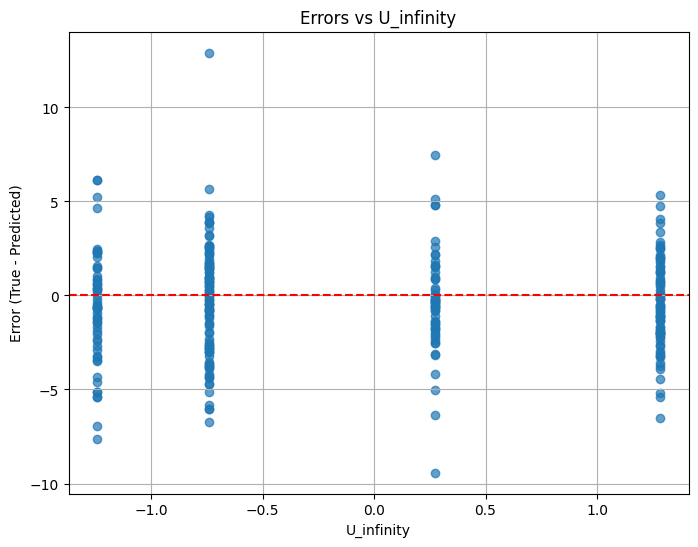

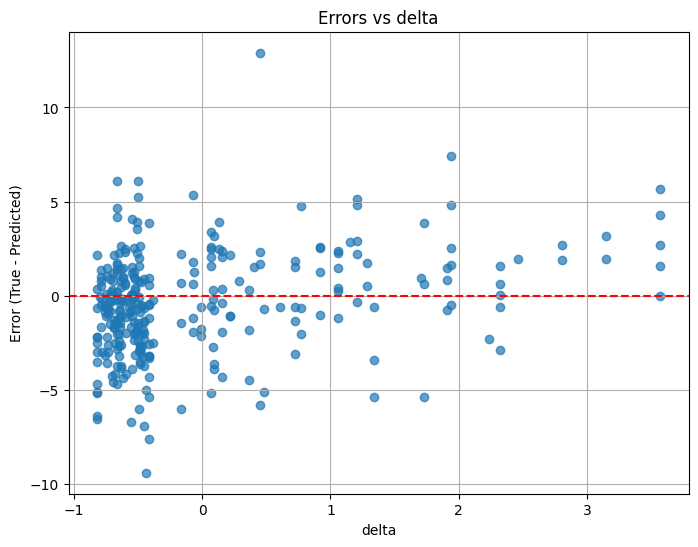

Mean Error: -0.4390993017659239
Standard Deviation of Errors: 2.747954331929048
Mean Squared Error (MSE): 7.744061207178942


In [ ]:
errors = y_test - y_pred.flatten()  # Calculate residuals (errors)

# 1. Plotting the Distribution of Errors
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Prediction Errors")
plt.xlabel("SPL Error (True - Predicted, dB)")
plt.ylabel("Absolute Frequency")
plt.grid()
plt.show()

# 2. Plotting Errors Against True Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, errors, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')  # Zero error line
plt.title("SPL Errors vs True SPL Values")
plt.xlabel("True SPL Values (dB)")
plt.ylabel("SPL Error (True - Predicted, dB)")
plt.grid()
plt.show()

# 3. Plotting Errors Against Each Feature
features = ['f', 'alpha', 'c', 'U_infinity', 'delta']  # Replace with your actual feature names
X_test_df = pd.DataFrame(X_test, columns=features)

for feature in features:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test_df[feature], errors, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')  # Zero error line
    plt.title(f"Errors vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Error (True - Predicted)")
    plt.grid()
    plt.show()

# 4. Computing Metrics for Errors
mean_error = np.mean(errors)
std_error = np.std(errors)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Error: {mean_error}")
print(f"Standard Deviation of Errors: {std_error}")
print(f"Mean Squared Error (MSE): {mse}")